## __Byproduct Recovery Framework Tutorial__

The purpose of this tutorial is to introduce the __byproduct recovery decision framework__ (``determine_byproduct_recovery.py``), which is based on the criterion of whether the total annual revenue is non negative. This framework serves as a supporting tool to help determine whether certain critical minerals (CMs) and/or rare Earth elements (REEs) should be recovered. 

While this tutorial focuses on revenue-based decisions, byproduct recovery decisions can also be guided by other criteria—such as the abundance of the byproduct or its current market value.

The decision tree used in this tutorial is referenced from Chapter 8 of the book _Chemical engineering design: principles, practice and economics of plant and process design_ by Towler, Gavin, and Ray Sinnott, Butterworth-Heinemann, 2021.
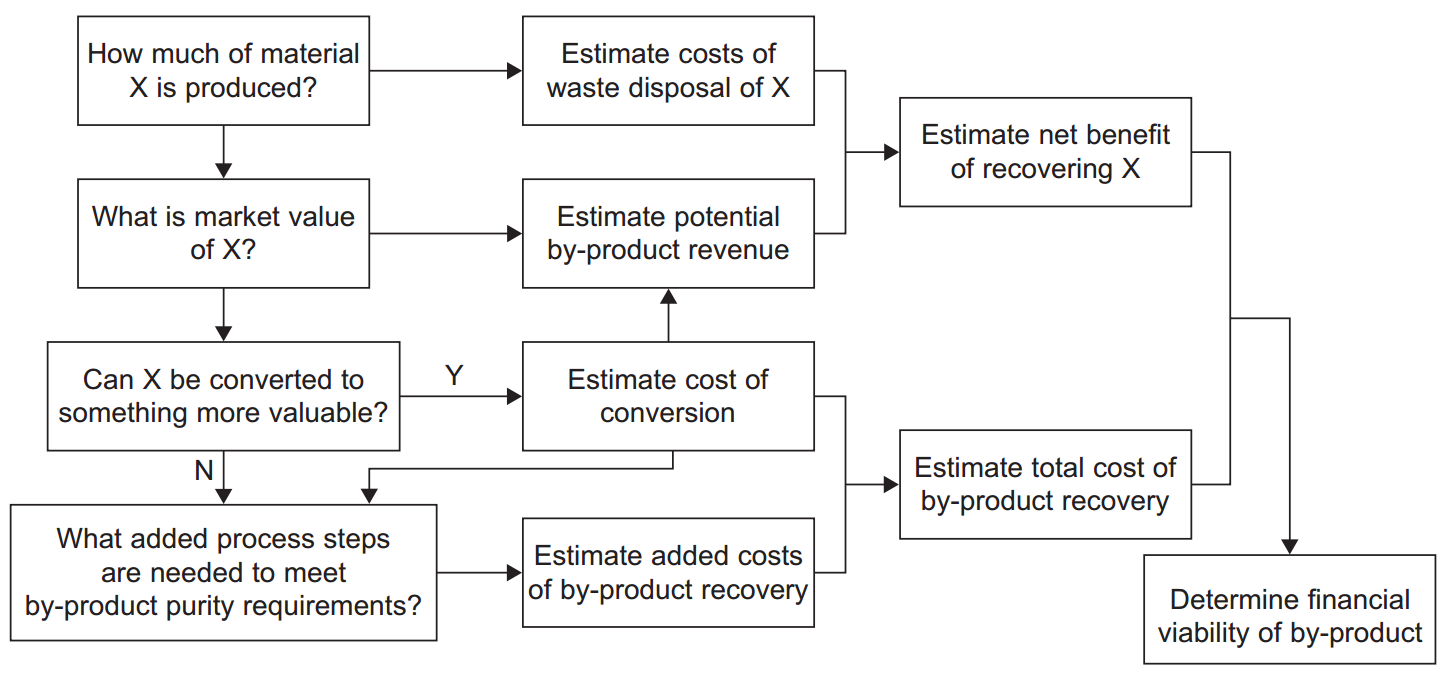

The framework includes a built in hypothesis example that results in positive revenue. In this tutorial, we will also demonstrate how to apply this framework to assess whether __lithium__ and __colbolt__ should be recovered through a dialfiltration process. 

To use the byproduct recovery framework effectively, a byproduct recovery process must already be constructed. This is necessary to determine the __annualized cost__ and __annual revenue__ associated with recovery. Once the process model is built, users can import it—along with its corresponding cost and revenue—and apply the byproduct recovery framework to decide whether or not the byproduct should be recovered.

__Learning Objectives__: By the end of this tutorial, users will be able to:
- Decide and import the necessary Python packages
- Build a process flowsheet using a case study: __lithium-colbalt recovery via diafiltration__
- Apply the __byproduct recovery decesion framework__

## __Step 1: Import the Necessary Packages__

First, import the necessary Pyomo, IDAES, and PrOMMiS packages. These will be implemented at various stages throughout the tutorial.

If you haven't installed these packages yet, you can do so using the following commands:

For more detailed installation instructions, refer to the respective ``README.md`` files:
- Pyomo: https://github.com/Pyomo/pyomo/blob/main/README.md
- IDAES: https://github.com/IDAES/idaes-pse/blob/main/README.md

For install PrOMMiS packages, its requires a bit more steps, refer the ``README.me`` file for details: https://github.com/prommis/prommis/blob/main/README.md

### __Package Purposes__
- Pyomo: Used for model construction and optimization.

- IDAES: While not essential for this specific tutorial, IDAES models can support model testing and validation.

- PrOMMiS:

    - ``prommis.nanofiltration.diafiltration``: Used to build the lithium-cobalt diafiltration recovery process model.

    - ``prommis.uky.costing.costing_dictionaries``: Provides product pricing data.

    - ``prommis.uky.costing.determine_byproduct_recovery``: Implements the byproduct recovery decision framework.


In [1]:
# Pyomo packages
from pyomo.environ import (
    ConcreteModel,
    Expression,
    Param,
    TransformationFactory,
    Var,
    value,
)

# IDAES packages
from idaes.core.util.model_diagnostics import DiagnosticsToolbox
from idaes.core.util.model_statistics import degrees_of_freedom

import pytest

# PrOMMiS packages
from prommis.nanofiltration.diafiltration import (
    main,
    add_costing,
    add_objective,
    add_product_constraints,
    build_model,
    initialize_model,
    print_information,
    set_scaling,
    solve_model,
    unfix_opt_variables,
)
from prommis.uky.costing.costing_dictionaries import load_default_sale_prices
from prommis.uky.costing.determine_byproduct_recovery import (
    ByproductRecovery,
    determine_example_usage,
)

## __Step 2: Flowsheet Puilding__

The lithium and colbolt diafiltration process has already been built and available in the repository: https://github.com/prommis/prommis/blob/main/src/prommis/nanofiltration/diafiltration.py.

To determine whether lithium and colbolt should be recovered, you'll first need to __import the diafiltration process__ and __access the cost and revenue__.

You can do this by referencing the process model defined in ``diafiltration.py``. Specifically, call the functions in the order specified within the ``main()`` function. Following this order is crucial because the diafiltration process consists of __three membrane stages__, and the model is built stage by stage. 

__Key Notes__:
- During each stage of model building:

    - Initialization is performed with a set of variables fixed.
    - When transitioning to the next stage:
        - Previously fixed variables must be unfixed.
        - New variables need to be fixed for the current stage.

This sequential initialization ensures that the model is stable and properly configured at each membrane stage.

In [2]:
m = build_model()
add_costing(m)
initialize_model(m)
solve_model(m)

unfix_opt_variables(m)
add_product_constraints(m, Li_recovery_bound=0.95, Co_recovery_bound=0.635)
add_objective(m)
set_scaling(m)
scaling = TransformationFactory("core.scale_model")
scaled_model = scaling.create_using(m, rename=False)
solve_model(scaled_model)
# Propagate results back to unscaled model
scaling.propagate_solution(scaled_model, m)

# Store results for later tests
total_annualized_cost = value(m.fs.costing.total_annualized_cost)

# recovery mass flow rate kg/hr
Li_recovery_mass = value(
    m.fs.stage3.permeate_outlet.flow_vol[0]
) * value(m.fs.stage3.permeate_outlet.conc_mass_solute[0, "Li"])
Co_recovery_mass = value(
    m.fs.stage1.retentate_outlet.flow_vol[0]
) * value(m.fs.stage1.retentate_outlet.conc_mass_solute[0, "Co"])

WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,1].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,2].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,3].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,4].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,5].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting 

## __Step 3: Test the Byproduct Recovery Framework__

With the mass balance from previous step, the next task is to calculate the __cost__ and evaluate __economic feasibility__. 

__1. Specify Product Prices__

Product prices are stored in ``costing_dictinary.py``. You can access the default sale prices using the function ``load_default_sale_prices()`` :

In [3]:
sale_prices = load_default_sale_prices()
Li_price = sale_prices["Li"]
Co_price = sale_prices["Co"]

These prices will be used to compute __annual revenue__, which is a key input to the byproduct recovery decision framework.

__2. Specify the Product Putputs__

Next, define the __products__ recovered from the byproduct recovery plant.

The __byproduct recovery framework__ accepts flexible inputs, where products are listed in a structure called ``material_list``, and their associated data (e.g. flow rate, price) are organized in a dictionary called ``material_data``.
- ``material_list``: A list of product names (strings).
- ``material_data``: A dictionary where each key corresponds to a product name and maps to its properties such as flow rate and price.

This structured input will be passed into the byproduct recovery decision framework to assess economic viability.

In [4]:
# The framework take flexible material input
material_list = ["Lithium", "Cobalt"]

# Introduce the byproduct recovery framework
model = ConcreteModel()
model.recovery_determine = ByproductRecovery(materials=material_list)

# Define input values based on provided materials
material_data = {
    "Lithium": {
        "production": Li_recovery_mass,
        "market_value": Li_price,
        "waste_disposal": 1,
        "conversion": 0,
        "conversion_cost": 0,
        "process_steps": 1,
        "process_cost": total_annualized_cost,
    },
    "Cobalt": {
        "production": Co_recovery_mass,
        "market_value": Co_price,
        "waste_disposal": 1,
        "conversion": 0,
        "conversion_cost": 0,
        "process_steps": 0,
        "process_cost": 0,
    },
}

__3. Set Additional Parameters and Evaluate Net Benefit__

To evaluate the economic feasibility, we must define additional parameters for each product:

- ``"waste_disposal"``: Set to ``1`` to indicate that waste disposal costs are considered.

- ``"conversion"``: Set to ``0`` if no conversion process is required to recover the material.

- ``"conversion_cost"``: Set to ``0`` when conversion is not needed.

- ``"process_steps"``: Set to ``0`` if no additional steps are needed beyond the current recovery process.

In this case, the lithium–cobalt diafiltration plant recovers ``both lithium and cobalt in a single process``. No additional purification or recovery steps are considered for either product. As such:

- The ``process cost`` is only accounted for once under ``"Lithium"`` production (though it could alternatively be placed under ``"Cobalt"`` with no impact on results).

- ``Both products are assumed to be sold at market prices``, regardless of purity level.

In [5]:
# Set values based on material list
for m in material_list:
    data = material_data.get(m, {})
    model.recovery_determine.material_production[m].set_value(
        data.get("production", 0)
    )
    model.recovery_determine.market_value[m].set_value(
        data.get("market_value", 0)
    )
    model.recovery_determine.waste_disposal_cost[m].set_value(
        data.get("waste_disposal", 0)
    )
    model.recovery_determine.conversion_possible[m].set_value(
        data.get("conversion", 0)
    )
    model.recovery_determine.conversion_cost[m].set_value(
        data.get("conversion_cost", 0)
    )
    model.recovery_determine.added_process_steps[m].set_value(
        data.get("process_steps", 0)
    )
    model.recovery_determine.added_process_cost[m].set_value(
        data.get("process_cost", 0)
    )

> 💡 **Note:** The `0` in `data.get("production", 0)` does not mean zero production. 
It indicates that the production rate is assumed to be **steady-state** (i.e., constant over time), not time-varying.

__4. Calculate the Overall Net Benefit__

After setting parameters such as production rate, market price, and associated costs for each product, you can use the byproduct recovery framework to calculate the overall net benefit.

The __overall net benefit__ is used to determine profitability:

- If ``net_benefit_value`` > 0 → The byproduct recovery process is __profitable__.

- If ``net_benefit_value`` ≤ 0 → The process is __not profitable__.

In [6]:
potential_revenue = value(model.recovery_determine.potential_revenue)
assert potential_revenue >= 0, "Potential revenue should be non-negative."

determine_result = model.recovery_determine.determine_financial_viability()
assert isinstance(
    determine_result, str
), f"Expected a string message, but got {type(determine_result)}"

# Check the output string for financial viability
net_benefit_value = value(model.recovery_determine.net_benefit)
assert net_benefit_value == pytest.approx(-211162.615, rel=1e-4)

if net_benefit_value > 0:
    expected_message = f"✅ Byproduct recovery is financially viable. Net Benefit: ${net_benefit_value:.2f}"
else:
    expected_message = f"❌ Byproduct recovery is NOT financially viable. Loss: ${-net_benefit_value:.2f}"

assert (
    determine_result == expected_message
), f"Unexpected output: {determine_result}"

print("\n--- Byproduct Recovery Decision ---")
print(determine_result)


--- Byproduct Recovery Decision ---
❌ Byproduct recovery is NOT financially viable. Loss: $211162.61


> ✅ **Note:** The `assert` statements are included to verify that the model is built as expected.  
> They are helpful for testing and debugging, but **not required** for using the byproduct recovery framework.